In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
import monai.transforms as T
from monai.utils.misc import first

from medmnist.dataset import RetinaMNIST
from medmnist.info import DEFAULT_ROOT

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [3]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(60, 10))
    for i, img in enumerate(imgs):
        ndarr = img.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        img = Image.fromarray(ndarr)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [10]:
device = 'cuda:0'
conf = retina128_autoenc_130M()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 122.59 M


In [6]:
batch_size = 1

train_transform = T.Compose([
                ToTensor(),
                T.RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
                T.RandFlip(spatial_axis=[-1, -2], prob=0.5),
                T.RandGridDistortion(prob=0.5),
                T.RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
                T.ScaleIntensity(),
            ])
dataset_train =  RetinaMNIST(split="train", 
        transform=train_transform, 
        download=True, 
        as_rgb=True, 
        size=128, 
        root="/DATA/NAS/datasets_source/other")

train_loader = DataLoader(dataset_train, batch_size, shuffle=False, num_workers=8, pin_memory=True)

Using downloaded and verified file: /DATA/NAS/datasets_source/other/retinamnist_128.npz


In [5]:
batch_size = 1
val_transform = T.Compose([
                ToTensor(),
                T.ScaleIntensity(),
            ])
dataset_val =  RetinaMNIST(split="val", 
        transform=val_transform, 
        download=True, 
        as_rgb=True, 
        size=128, 
        root="/DATA/NAS/datasets_source/other")

val_loader = DataLoader(dataset_val, batch_size, shuffle=False, num_workers=8, pin_memory=True)

Using downloaded and verified file: /DATA/NAS/datasets_source/other/retinamnist_128.npz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


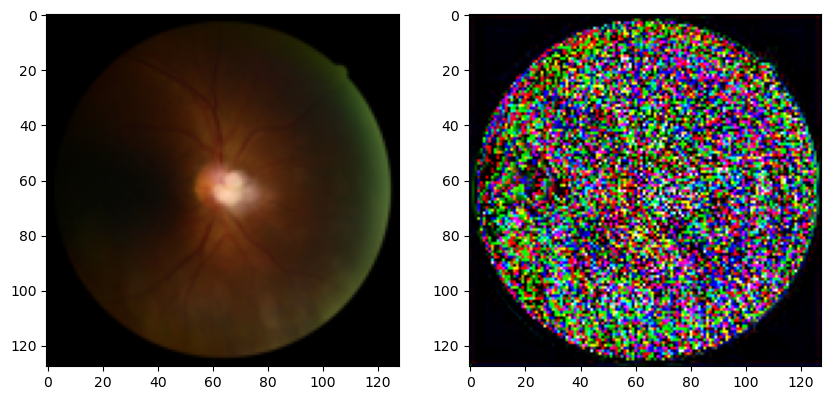

In [7]:
orig = first(val_loader)[0].to(device)
cond = model.encode(orig, ema=True)
xT = model.encode_stochastic(orig, cond, T=250, ema=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(orig[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


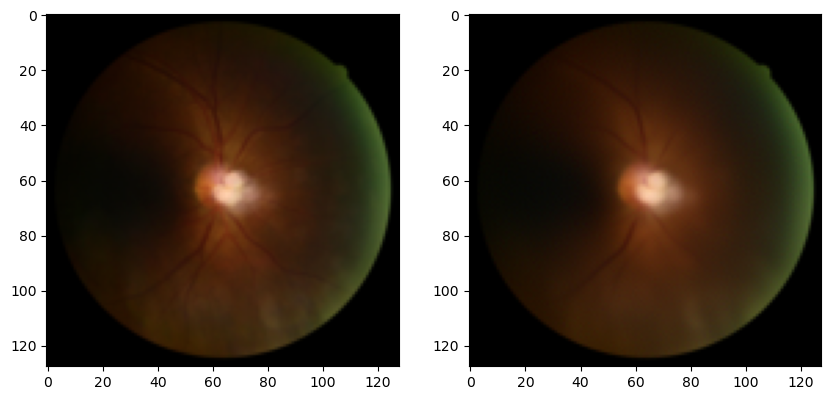

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
recon = model.render(xT, cond, T=100, ema=True)

ax[0].imshow(orig[0].permute(1, 2, 0).cpu())
ax[1].imshow(recon[0].permute(1, 2, 0).cpu())

In [9]:
with torch.no_grad():
    train_latents = list()
    train_labels = list()
    for batch in tqdm(train_loader):
        img = batch[0]
        cond = model.encode(img.to(device), ema=True)
        cond = cond.cpu()

        train_latents.append(cond)
        train_labels.append(batch[1].item())

    train_latents_np = torch.cat(train_latents, dim=0).cpu().detach().numpy()
    train_labels_np = np.array(train_labels).ravel()


    val_latents = list()
    val_labels = list()
    for batch in tqdm(val_loader):
        img = batch[0]
        cond = model.encode(img.to(device), ema=True)
        cond = cond.cpu()

        val_latents.append(cond)
        val_labels.append(batch[1].item())

    val_latents_np = torch.cat(val_latents, dim=0).cpu().detach().numpy()
    val_labels_np = np.array(val_labels).ravel()

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [10]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([486, 128, 206, 194,  66]))

In [16]:
latents = {
    "train": {"latents": train_latents_np, "labels": train_labels_np},
    "val": {"latents": val_latents_np, "labels": val_labels_np}
} 

torch.save(latents, "/home/matan/latent_dae/diffae/latents/retina_latents.pt")

In [3]:
latents = torch.load("latents/retina_latents.pt")
train_latents_np = latents["train"]["latents"]
train_labels_np = latents["train"]["labels"]
val_latents_np = latents["val"]["latents"]
val_labels_np = latents["val"]["labels"]

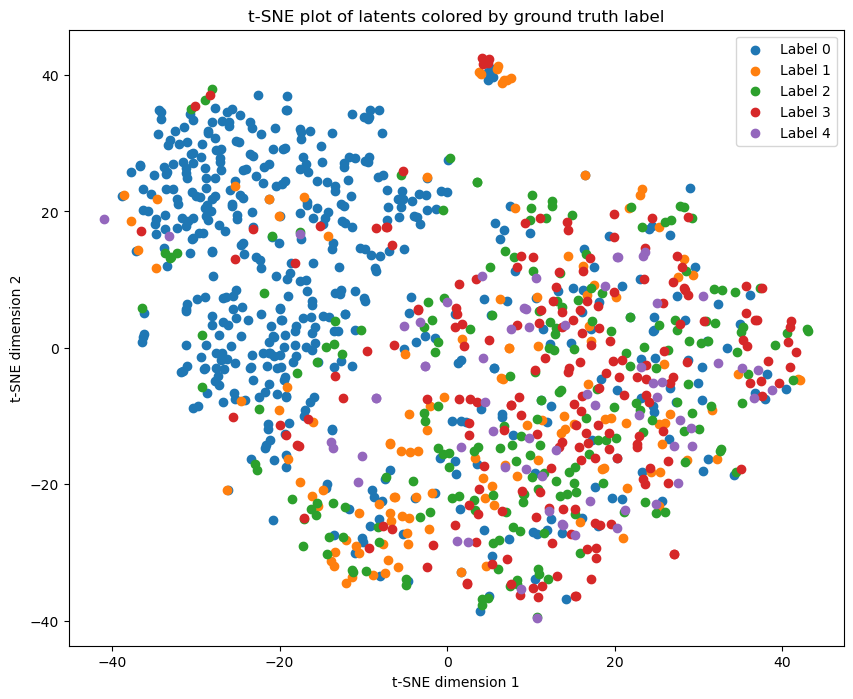

In [11]:
from sklearn.manifold import TSNE

# Run t-SNE on the dataset
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(train_latents_np)

# Plotting the result, coloring by label
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels_np):
    plt.scatter(latents_2d[train_labels_np == label, 0], latents_2d[train_labels_np == label, 1], label=f'Label {label}')

plt.legend()
plt.title('t-SNE plot of latents colored by ground truth label')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

Linear classifier

In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# Convert labels to binary: 0 stays 0, anything above 0 becomes 1
y_train = (train_labels_np > 0).astype(int)
y_test = (val_labels_np > 0).astype(int)

# Train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear', random_state=42)  # Using a linear kernel
svm_model.fit(train_latents_np, y_train)

# Predict on the test set
svm_predictions = svm_model.predict(val_latents_np)

# Evaluate the models
svm_accuracy = accuracy_score(y_test, svm_predictions)

print("SVM Accuracy:", svm_accuracy)

f1 = f1_score(y_test, svm_predictions)
print("SVM F1:", f1)

auc = roc_auc_score(y_test, svm_predictions)
print("SVM AUC:", auc)

SVM Accuracy: 0.85
SVM F1: 0.8783783783783784
SVM AUC: 0.835016835016835


In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# Convert labels to binary: 0 stays 0, anything above 0 becomes 1
y_train = (train_labels_np > 0).astype(int)
y_test = (val_labels_np > 0).astype(int)

# Train a Support Vector Machine (SVM) model
lr_model = LogisticRegression(random_state=42)  # Using a linear kernel
lr_model.fit(train_latents_np, y_train)

# Predict on the test set
lr_predictions = lr_model.predict(val_latents_np)

# Evaluate the models
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("SVM Accuracy:", lr_accuracy)

f1 = f1_score(y_test, lr_predictions)
print("SVM F1:", f1)

auc = roc_auc_score(y_test, lr_predictions)
print("SVM AUC:", auc)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


NameError: name 'svm_model' is not defined

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

latnets_mean = np.mean(train_latents_np, axis=0)
latnets_std = np.std(train_latents_np, axis=0)

# Assuming train_latents_np and val_latents_np are your training and validation feature matrices
w = svm_model.coef_
b = svm_model.intercept_

# Normalize w for the distance computation
w = w / np.linalg.norm(w)

# Compute the distance from the hyperplane for training and validation sets
train_distances = np.dot(train_latents_np, w.T) + b 
val_distances = np.dot(val_latents_np, w.T) + b


# Fit the linear model
lin_model = LinearRegression()
lin_model.fit(train_distances, train_labels_np)

# Predict on the validation set
lin_predictions = lin_model.predict(val_distances)

mae = mean_absolute_error(val_labels_np, lin_predictions)
print("MAE:", mae)

auc = f1_score(val_labels_np, lin_predictions.round(), average="macro")
print("SVM F1:", auc)


MAE: 0.7280482729456691
SVM F1: 0.3143505227715754


Editing

In [17]:
def move_across_boundary(sample, svm_model, gt_grade):
    dists = list()

    w = svm_model.coef_ 
    w = w / (np.linalg.norm(w) * np.sqrt(512))
    b = svm_model.intercept_

    # Decision function value for the original sample
    decision_value = np.dot(w, sample.T) + b
    reg_value = np.round(lin_model.predict(decision_value)[0])
    dists.append((decision_value[0][0], reg_value))
    print("Before (Dist, Reg): ", decision_value[0][0], reg_value)


    # normalize sample before editing
    sample = (sample - latnets_mean) / latnets_std
    
    # Determine the direction to move the sample based on its initial classification
    direction = 1 if gt_grade in [0, 1] else -1
    
    # Modify the sample
    edited = list()
    for step_size in np.arange(100, 1001, 200):
        modified_sample = sample + direction * step_size * w
        modified_sample = modified_sample * latnets_std + latnets_mean

        decision_value =  np.dot(w, modified_sample.T) + b
        reg_value = np.round(lin_model.predict(decision_value)[0])
        dists.append((decision_value[0][0], reg_value))
        modified_sample = torch.tensor(modified_sample, requires_grad=False, device=device).float()

        edited.append(modified_sample)

    print(dists)
    
    return edited

GT Grade:  3
Before (Dist, Reg):  -0.4269475350484187 1.0
[(-0.4269475350484187, 1.0), (-0.457682738772284, 1.0), (-0.5191531470117613, 1.0), (-0.5806235552512387, 0.0), (-0.642093963490716, 0.0), (-0.7035643717301934, -0.0)]
5


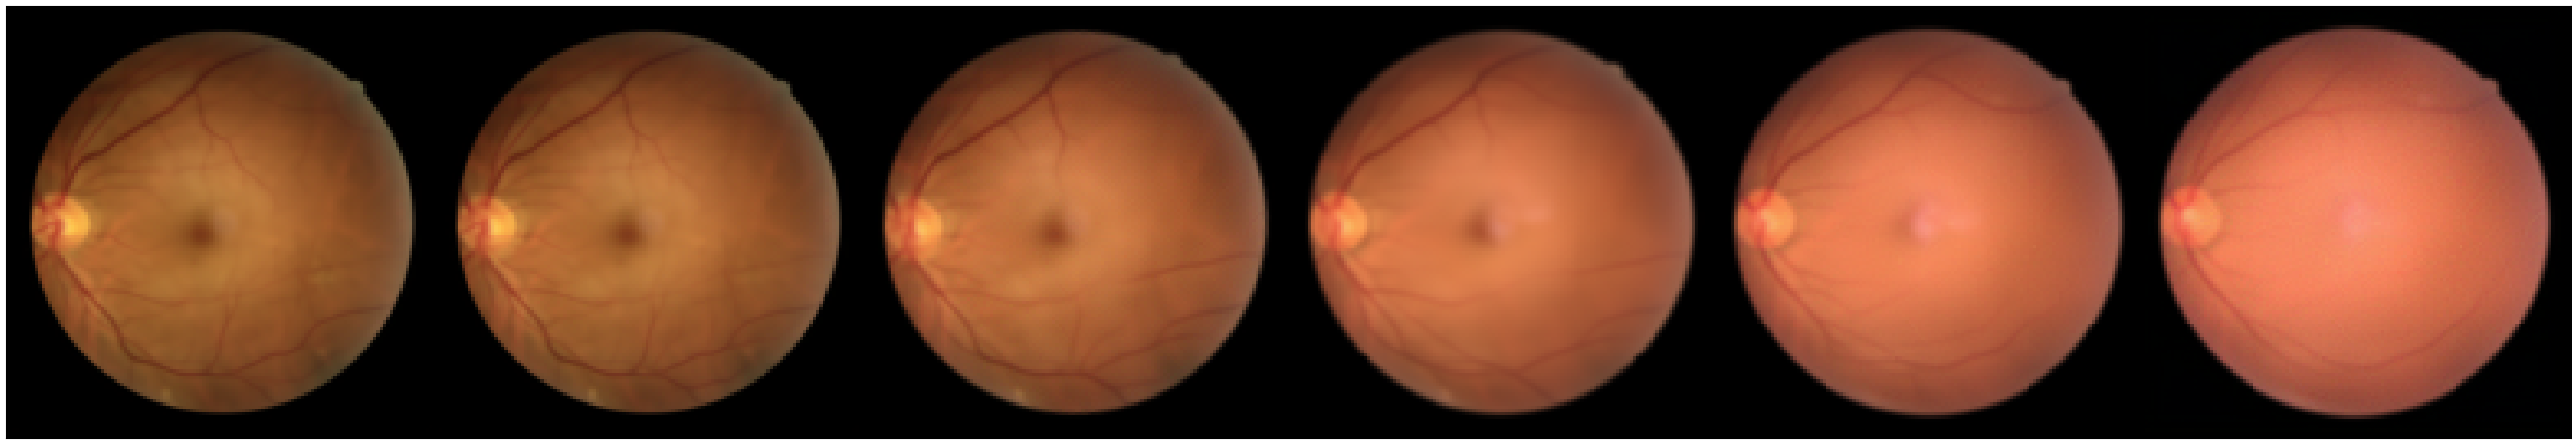

In [18]:
for i, batch in enumerate(val_loader):
    gt_grade = batch[1].item()
    if gt_grade != 0:
        continue
    
    print("GT Grade: ", gt_grade)
    orig_img = batch[0].to(device)
    
    cond =  model.encode(orig_img, ema=True)
    xT = model.encode_stochastic(orig_img, cond, T=250, ema=True)
    recon_img = model.render(xT, cond, T=100, ema=True)

    with torch.no_grad():
        edit_conds = move_across_boundary(cond, svm_model, gt_grade)
    
    edit_imgs = model.render(torch.cat([xT for i in range(len(edit_conds))]), torch.cat(edit_conds, dim=0), T=100, ema=True)
    grid = torchvision.utils.make_grid(torch.cat([edit_imgs, recon_img], dim=0))
    show(grid)
    plt.show(block=False)

    if i > 0:
        break
